# Project #2 : Continuous Control

## DDPG Multi Agent Implementation

---

This notebook implements my solution for the Continous Control project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Install Python Packages

If needed, run this command to install a few packages in your computing environment.  This line will take a few minutes to run!

In [1]:
#!pip -q install ./python

### 2. Import libraries

In [2]:
import torch
import numpy as np
from collections import deque
#import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment

### 3. Instantiate the Unity Reacher environment

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
# my iMac 
env = UnityEnvironment(file_name="Reacher.app")

# Udacity Workspace
#env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

# AWS instance
#env = UnityEnvironment(file_name='./Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment and activate the training mode
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


### 4. Instantiate the Agent

In [12]:
from ddpg_agent import DDPG_MultiAgent
agent = DDPG_MultiAgent(state_size, action_size, num_agents)

### 5. Train the Agent

In [13]:
def train(n_episodes=20, max_t=200):
    
    ''' Deep Deterministic Policy Gradient (DDPG) Algorithm for multiple agents.
        The code is derived from the 'ddpg-pendulum' code provided by Udacity.
        The code is modified to work with the Unity Reacher environment for multiple agents,
        calculate the average score across agents and a sliding window of epsiodes, and 
        stop the algorithm when the target average score is reached.
        
        Arguments:
            n_episodes : number of episodes
            max_t      : maximum number of timesteps per episode
        '''
    
    # training parameters
    k_target_score = 30.0  # Score that must be met to be considered solved
    k_sliding_window = 100 # number of episodes used to calculate mean to check if solution satisified
    k_print_every = 1     # How often to keep a persistent version of printout

    # variables to track progress
    scores_deque = deque(maxlen = k_sliding_window) # store scores of last k_sliding_window episodes
    scores = []           # store score of every episode
    max_average_score = -np.Inf   # the highest average episode score achieved across all episodes
    
    # start time to track total training time
    t0 =  time.time()
    
    # training loop
    for i_episode in range(1, n_episodes+1):
        
        # reset the environments
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        # reset the agents
        agents.reset()
        
        # reset the episode score for each agent
        episode_scores = 0
        
        # run an experience on each agent
        for t in range(max_t):
            # send state to each agent and collect their action
            actions = agents.act(states)
            
            # send actions to the environments
            env_info = env.step(actions)[brain_name]
            
            # get next states
            next_states = env_info.vector_observations
            
            # get rewards
            rewards = env_info.rewards
            
            # get dones (True if agent reached the terminal state)
            dones = env_info.local_done
            
            # Save experiences in the replay memory,
            # and sample a batch of experiences from the replay memory to train the agents
            agents.step(states, actions, rewards, next_states, dones)
            
            # update the episode score and roll the states over for the next time step
            episode_scores += np.array(rewards)
            states = next_states
            
            if np.any(dones):
                break

        # calculate the average episode score across all agents
        average_episode_score = np.mean(episode_scores)
        
        # update the sliding window of episode scores
        scores_deque.append(average_episode_score)
        
        # append the average episode score to the scores array 
        scores.append(average_episode_score)
        
        # update the average sliding score
        average_sliding_score = np.mean(scores_deque)
        
        # update time the training process has lasted thus far, in minutes
        total_training_time = (time.time()-t0)/60
        
        # after each episode, update the printout of the episode and sliding average scores
        print('\rEpisode {}\tAverage Score: {:.1f}\tScore: {:.1f}\tClock: '
            .format(i_episode, np.mean(scores_deque), average_episode_score), int(total_training_time), end="")
        
        # after every k_print_every episode, print the sliding average score
        if i_episode % k_print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.1f}'
                  .format(i_episode, average_sliding_score))
        
        # save the model weights if the average episode score improved
        if (i_episode >= k_sliding_window) and (average_episode_score > max_average_score):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            max_average_score = average_episode_score
        
        if average_sliding_score >= k_target_score:
            print('\n\nAgents are trained in {:d} episodes!\tAverage Score: {:.1f}\n'
                  .format(i_episode - k_sliding_window, average_score))
            break
            
    return scores

In [14]:
##### Train the agent #####

n_episodes = 5  # maximum number of episodes
max_t = 100        # maximum number of timesteps per episode

scores = train(n_episodes, max_t)

Episode 1	Average Score: 0.1	Score: 0.1	Clock:  0
Episode 2	Average Score: 0.1	Score: 0.1	Clock:  0
Episode 3	Average Score: 0.1	Score: 0.0	Clock:  0
Episode 4	Average Score: 0.1	Score: 0.1	Clock:  0
Episode 5	Average Score: 0.1	Score: 0.0	Clock:  0


### 6. Plot the Training Curve

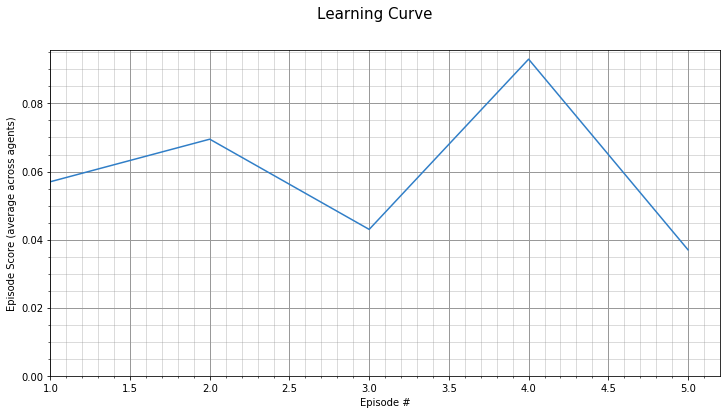

In [15]:
# plot and save the learning curve

#fig = plt.figure()
#ax = fig.add_subplot(111)
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle("Learning Curve", fontsize=15)
ax.plot(np.arange(1, len(scores)+1), scores, color="#307EC7", label="line")
ax.set_xlabel("Episode #")
ax.set_ylabel("Episode Score (average across agents)")
plt.xlim(left=1)
plt.ylim(bottom=0)
ax.grid(True)
ax.grid(b=True, which='major', color='#999999', linestyle='-', linewidth=1)
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.7, linewidth=0.5)
plt.show()
fig.savefig("ddpg_agent_learning_curve.jpg")

In [10]:
#env.close()